<a href="https://colab.research.google.com/github/luixmartins/text-classification-python/blob/main/spam_message_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/ivanfilhoreis/bertVectorizer.git -q
!pip install -U sentence-transformers -q 

    Running setup.py install for bertVectorizer ... done
  DEPRECATION: bertVectorizer was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
     |████████████████████████████████| 78 kB 3.1 MB/s 
     |████████████████████████████████| 3.5 MB 35.5 MB/s 
     |████████████████████████████████| 6.8 MB 39.5 MB/s 
     |████████████████████████████████| 1.2 MB 54.4 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 895 kB 55.8 MB/s 
     |████████████████████████████████| 596 kB 64.9 MB/s 


In [39]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from bertVectorizer import bertVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split 
from sklearn.metrics import confusion_matrix, classification_report 

%matplotlib inline 

#link to dataframe 
path = 'https://raw.githubusercontent.com/luixmartins/text-classification-python/main/datasets/spam_text_message.csv'
df = pd.read_csv(path)

df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [28]:
#Verify null values 
df.isnull().value_counts()

Category  Message
False     False      5572
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


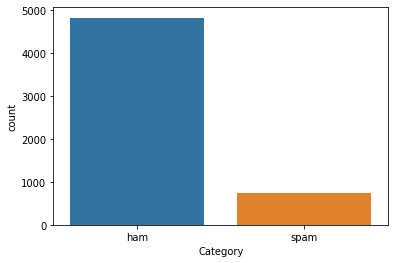

In [29]:
#Countplot from categories 
sns.countplot(df['Category'])

In [30]:
df.columns = ['label', 'text']
df['label'] = [1 if category == 'spam' else 0 for category in df['label']]

df['label'].value_counts()

0    4825
1     747
Name: label, dtype: int64

In [31]:
models = [
          RandomForestClassifier(n_estimators=100, max_depth=5),
          MLPClassifier(),
          KNeighborsClassifier(),
          SVC(),
          GaussianNB(),
]

In [32]:
vectorizer = bertVectorizer()

X = vectorizer.fit_transform(df).values 
labels = np.array(df['label'])

Downloading:   0%|          | 0.00/736 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/679 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [33]:
#Choose best model using cross validation 
cv_df = pd.DataFrame(index=range(5 * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X, labels, scoring='accuracy', cv=5)

  for fold_index, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_index, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_index', 'accuracy'])

In [34]:
#show the mean and standard deviation 
mean = cv_df.groupby('model_name').accuracy.mean()
std = cv_df.groupby('model_name').accuracy.std()

result_cv = pd.concat([mean, std], axis=1, ignore_index=True)
result_cv.columns = ['Mean Accuracy', 'Standard Deviation']

result_cv 

,Mean Accuracy,Standard Deviation
model_name,,
GaussianNB,0.827351,0.007089
KNeighborsClassifier,0.976130,0.004564
MLPClassifier,0.982233,0.004848
RandomForestClassifier,0.966617,0.005488
SVC,0.985642,0.002840


In [35]:
#Split train and test 
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=42, stratify=labels)

In [49]:
clf = SVC(kernel='poly', degree=2)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, output_dict=False))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1206
           1       0.97      0.91      0.94       187

    accuracy                           0.98      1393
   macro avg       0.98      0.96      0.97      1393
weighted avg       0.98      0.98      0.98      1393



Text(69.0, 0.5, 'True')

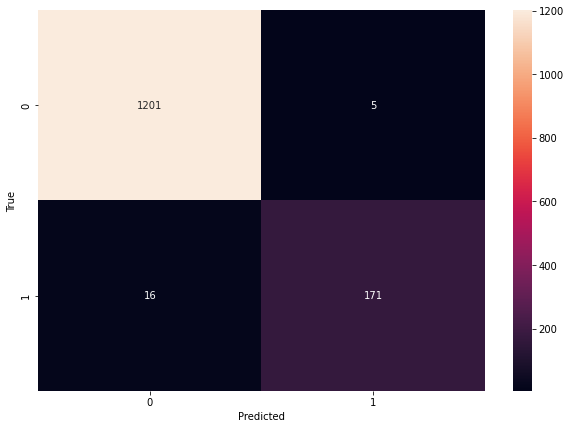

In [50]:
cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')